Let's try generating a DC-SBM properly and then do the PPR stuff again.  This way we don't have to worry about errors translating from the SBM.

10 communities w/ 100 nodes each, 1 one with 1,000

In [464]:
import numpy as np
from scipy.integrate import trapz

In [494]:
# block membership matrix
Z = np.zeros((2000, 11), dtype=int)

sizes = np.append(np.array([100]*10), 1000)
C = len(sizes)
N = sizes.sum()

thresholds = np.zeros(len(sizes) + 1, dtype=int)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

for i in range(C):
    Z[thresholds[i]:thresholds[i+1]][:,i] = 1

    
# mixing matrix
# average of 8 edges between the smaller off-diagonal classes
B = np.ones((C,C)) * 8
B[:,-1] *= 10
B[-1, :] *= 10

for i in range(C -1):
    B[i,i] = 3200
    
B[-1,-1] = 320000

# theta should sum to 1 for each block
theta = np.ones(N)
theta[:1000] *= 1e-2
theta[1000:] *= 1e-3

assert theta.sum() == C

# generate random graph
A = np.zeros((N,N), dtype=int)
rng = np.random.default_rng(7777778)
choices = rng.uniform(size=N*(N-1)//2)

# probabilities for each pair of nodes
theta = np.diag(theta)
p = (theta @ Z @ B @ Z.T @ theta)

# this sucks but yeet
A = np.zeros((N,N), dtype=int)

k = 0
for i in range(N):
    for j in range(i+1, N):
        if choices[k] < p[i,j]:
            A[i,j] = 1
            A[j,i] = 1
        k+=1

In [495]:
for i in range(C):
    print(A[thresholds[i]:thresholds[i+1]].sum() - B.sum(axis=0)[i])

88.0
-110.0
-92.0
-37.0
29.0
-12.0
-21.0
-49.0
48.0
47.0
-757.0


In [496]:
for i in range(C):
    print(
        A[thresholds[i]:thresholds[i+1], thresholds[i]:thresholds[i+1]].sum() - B[i,i])

86.0
-104.0
-102.0
-38.0
40.0
2.0
-24.0
-68.0
56.0
54.0
-746.0


In [497]:
B.sum(axis=0)

array([  3352.,   3352.,   3352.,   3352.,   3352.,   3352.,   3352.,
         3352.,   3352.,   3352., 320800.])

Ok I am satisfied.  This DC-SBM looks legit.

Compute blockwise PPR

In [498]:
# fix source node of PPR for now
u = 7
alpha = 0.3

pi = np.zeros(N)
pi[u] = 1

D = np.diag(B.sum(axis=0))
P = np.linalg.inv(D) @ B

alpha_pi_t = pi @ Z * alpha


inv_transform = np.linalg.inv(np.eye(C) - (1-alpha)*P)
p = alpha_pi_t @ inv_transform

# blockwise PPR vector
p

array([0.90456059, 0.00477533, 0.00477533, 0.00477533, 0.00477533,
       0.00477533, 0.00477533, 0.00477533, 0.00477533, 0.00477533,
       0.05246141])

In [499]:
from lassort.localassort import calculateRWRrange

# is this correct?
degree = A.sum(axis=0)
D = np.diag(1./degree, 0)
# construct transition matrix (row normalised adjacency matrix)
W = D @ A

pr = np.array([alpha])

pis, ti, it = calculateRWRrange(W, 100, pr, N)

In [500]:
ti[:100].sum()

0.0007084564687767997

In [501]:
ti[100:200].sum()

0.913508264314111

In [502]:
ti[200:300].sum()

0.0007069888864222242

In [503]:
ti[400:500].sum()

0.0011422256022391288

Ooookay...  I think this is right actually.

In [504]:
# compute expected  multiscale mixing
# egl - ar^2
ar2 = (B.sum(axis=0) / B.sum())**2

eggl = p * np.diag(B)/ B.sum(axis=0)


qmax = 1 - ar2.sum()
r_loc = (eggl.sum() - ar2.sum()) / qmax

r_loc

0.7597160126411407

In [436]:
from lassort import localAssortF
import networkx as nx

In [505]:
G = nx.convert_matrix.from_numpy_matrix(A)
E = nx.convert_matrix.to_pandas_edgelist(G).values[:,:2]


In [506]:
attr = []

for i in range(C - 1):
    attr.append(np.ones(100, dtype=int) * i)
    
attr.append(np.ones(1000, dtype=int)*10)

M = np.hstack(attr)
assortM, assortT, _ = localAssortF(E,M,pr=np.array([0.3]))
                                   
assortT

array([0.7992832 , 0.6635741 , 0.79227753, ..., 0.98362697, 0.9833658 ,
       0.96762478])

In [507]:
assortT[:1000].mean()

0.7563480046505685

This is close...

Let's try one in the big chonk

In [538]:
# fix source node of PPR for now
u = 1554
alpha = 0.3

pi = np.zeros(N)
pi[u] = 1

D = np.diag(B.sum(axis=0))
P = np.linalg.inv(D) @ B

alpha_pi_t = pi @ Z * alpha


inv_transform = np.linalg.inv(np.eye(C) - (1-alpha)*P)
p = alpha_pi_t @ inv_transform

# compute expected  multiscale mixing
# egl - ar^2
ar2 = (B.sum(axis=0) / B.sum())**2

eggl = p * np.diag(B)/ B.sum(axis=0)


qmax = 1 - ar2.sum()
r_loc = (eggl.sum() - ar2.sum()) / qmax

r_loc

0.984786876776065

In [539]:
assortT[1000:].mean()

0.9853749271956477

In [682]:
def predict_msm_block(B, theta, Z, pr):
    """
    predict multiscale mixing based on a DC-SBM
    mixing matrix
    
    Returns
    -------
    
    predM : array_like 
        C x len(pr) array of expected local assortativities for each block.
        predM[C, i] corresponds to the expected local assortativity of nodes
        in cluster C with alpha = i
    
    predT : array_like
        C x 1 array of expected multiscale assortattivities for each block.
        predT[C] is the expected multiscale assortativity for community C
    """
    D = np.diag(B.sum(axis=0))
    P = np.linalg.inv(D) @ B
    
    ar2 = (B.sum(axis=0) / B.sum())**2
    qmax = 1 - ar2.sum()
    
    predM = np.zeros((C, len(pr)))
    predT = np.zeros((C,1))

    for i in range(C):
        u = np.where(Z[:,i]==1)[0][0]
        
        for j, alpha in enumerate((1-pr)):
            pi = np.zeros(N)
            pi[u] = 1
            
            alpha_pi_t = pi @ Z * alpha
            inv_transform = np.linalg.inv(np.eye(C) - (1-alpha)*P)
            
            # p is blockwise PPR
            p = alpha_pi_t @ inv_transform
            
            # compute multiscale mixing from PPR
            eggl = p * np.diag(B)/ B.sum(axis=0)
            predM[i,j] = (eggl.sum() - ar2.sum()) / qmax
            
            
    # use the trapezoid rule to estimate predT
    delta = (pr - np.roll(pr,1))[1:]

    traps = (predM + np.roll(predM, 1))[:,1:] / 2
    predT = (traps * delta).sum(axis=1) / pr.max()
    return predM, predT
            

def predict_msm(A,M):
    """
    for any given network, predict multiscale mixing
    for each node
    """
    return 0
    
    
pr = np.arange(0,1,0.1)
predM, predT = predict_msm_block(B, theta, Z, pr)
predM

array([[0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
        0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009],
       [0.74718223, 0.74781394, 0.7485984

In [606]:
G = nx.convert_matrix.from_numpy_matrix(A)
E = nx.convert_matrix.to_pandas_edgelist(G).values[:,:2]

attr = []

for i in range(C - 1):
    attr.append(np.ones(100, dtype=int) * i)

attr.append(np.ones(1000, dtype=int)*10)

M = np.hstack(attr)
assortM, assortT, _ = localAssortF(E,M,pr=pr)

assortM

array([[0.85316905, 0.83960335, 0.82701056, ..., 0.78218242, 0.77903605,
        0.77971311],
       [0.5623862 , 0.58176878, 0.60140709, ..., 0.70728298, 0.73215838,
        0.76008327],
       [0.82001368, 0.81485092, 0.8095455 , ..., 0.7841836 , 0.78172993,
        0.78252029],
       ...,
       [0.98277909, 0.98298611, 0.98318667, ..., 0.9838417 , 0.98383517,
        0.9837542 ],
       [0.98245416, 0.9826518 , 0.98284934, ..., 0.98361351, 0.98365966,
        0.98364375],
       [0.95203803, 0.95517684, 0.95831525, ..., 0.97376282, 0.97674087,
        0.97965595]])

In [683]:
assortM[:1000].mean(axis=0)

array([0.74974058, 0.75050938, 0.75142398, 0.75254437, 0.75396776,
       0.75585805, 0.7584982 , 0.76237881, 0.76834125, 0.77779889])

In [684]:
assortM[1000:].mean(axis=0)

array([0.98628823, 0.98618406, 0.98606492, 0.9859257 , 0.98576   ,
       0.98556018, 0.98531736, 0.9850214 , 0.98466092, 0.98422327])

In [685]:
predM[2]

array([0.74718223, 0.74781394, 0.7485984 , 0.74959865, 0.75091793,
       0.7527378 , 0.75540993, 0.75971601, 0.76781477, 0.78866009])

In [686]:
assortM[:1000].mean(axis=0)

array([0.74974058, 0.75050938, 0.75142398, 0.75254437, 0.75396776,
       0.75585805, 0.7584982 , 0.76237881, 0.76834125, 0.77779889])

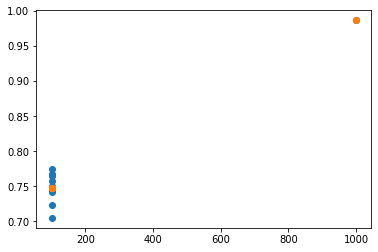

In [687]:
from matplotlib import pyplot as plt
alpha = 0

y = []

for i in range(C):
    y.append(assortM[thresholds[i]:thresholds[i+1] , alpha].mean())
    
plt.scatter(Z.sum(axis=0), y)

plt.scatter(Z.sum(axis=0), predM[:,alpha])

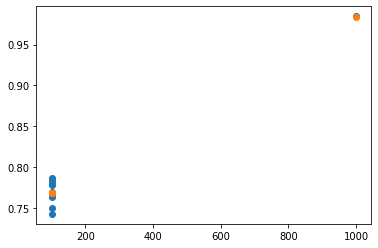

In [688]:
alpha = 8

y = []

for i in range(C):
    y.append(assortM[thresholds[i]:thresholds[i+1] , alpha].mean())
    
plt.scatter(Z.sum(axis=0), y)

plt.scatter(Z.sum(axis=0), predM[:,alpha])

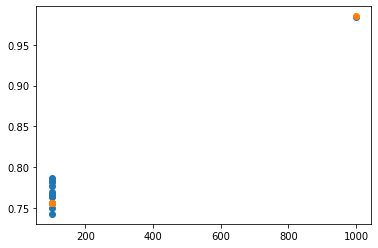

In [690]:
y = []

for i in range(C):
    y.append(assortM[thresholds[i]:thresholds[i+1] , alpha].mean())

plt.scatter(Z.sum(axis=0),y)
plt.scatter(Z.sum(axis=0),predT)

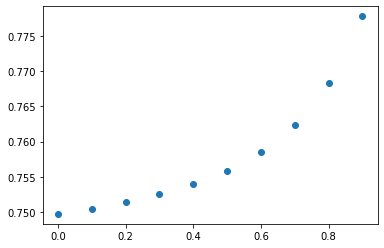

In [618]:
plt.scatter(pr, assortM[:1000].mean(axis=0))

In [644]:
trapz(assortM[:1000].mean(axis=0),pr) / 0.9

0.7574768365544177

In [643]:
assortT[1000:].mean()

0.9853749271956477

In [647]:
delta = (pr - np.roll(pr,1))[1:]

y =  assortM[:1000].mean(axis=0)

traps = (y + np.roll(y, 1))[1:] / 2

(traps * delta).sum() / pr.max()

0.7574768365544177

In [681]:
delta = (pr - np.roll(pr,1))[1:]

traps = (predM + np.roll(predM, 1))[:,1:] / 2
(traps * delta).sum(axis=1) / pr.max()

array([0.75561429, 0.75561429, 0.75561429, 0.75561429, 0.75561429,
       0.75561429, 0.75561429, 0.75561429, 0.75561429, 0.75561429,
       0.98521546])

In [679]:
(traps * delta).sum(axis=1) / pr.max()

array([0.75561429, 0.75561429, 0.75561429, 0.75561429, 0.75561429,
       0.75561429, 0.75561429, 0.75561429, 0.75561429, 0.75561429,
       0.98521546])

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])